# 프로젝트 : 주식 예측에 도전해 보자

시계열 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = '/content/drive/MyDrive/aiffel/stock_prediction/MSFT.csv'  # 마이크로소프트 주식
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
ts.head()

Date
2021-07-26    289.049988
2021-07-27    286.540009
2021-07-28    286.220001
2021-07-29    286.500000
2021-07-30    284.910004
Name: Close, dtype: float64

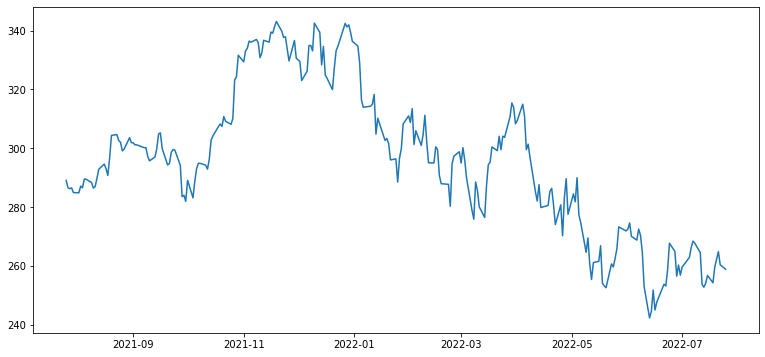

In [2]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 준다.

# 시계열(time series) 데이터를 차트로 그려 본다. 특별히 더 가공하지 않아도 잘 그려진다.
plt.plot(ts)

**각종 전처리 수행**

In [3]:
# 결측치가 있다면 이를 보간한다. 보간 기준은 time을 선택한다.
ts=ts.interpolate(method='time')
ts[ts.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력한다.

Series([], Name: Close, dtype: float64)

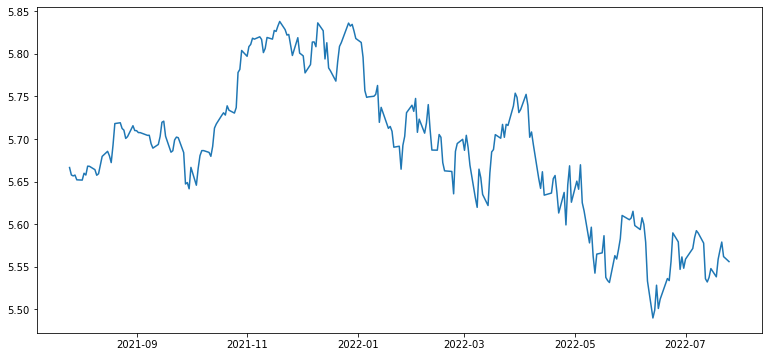

In [4]:
# 로그 변환 시도
ts_log = np.log(ts)
plt.plot(ts_log)

**사계열 안정성 분석**

In [5]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [6]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는  adfuller 메서드를 호출한다.
    dftest = adfuller(timeseries, autolag='AIC')

    # adfuller 메서드가 리턴한 결과를 정리하여 출력한다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Satistic','p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


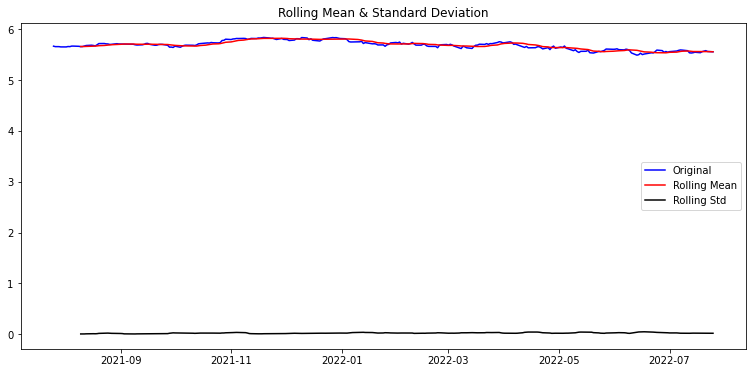

Results of Dickey-Fuller Test:
Test Satistic                   -1.380426
p-value                          0.591623
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


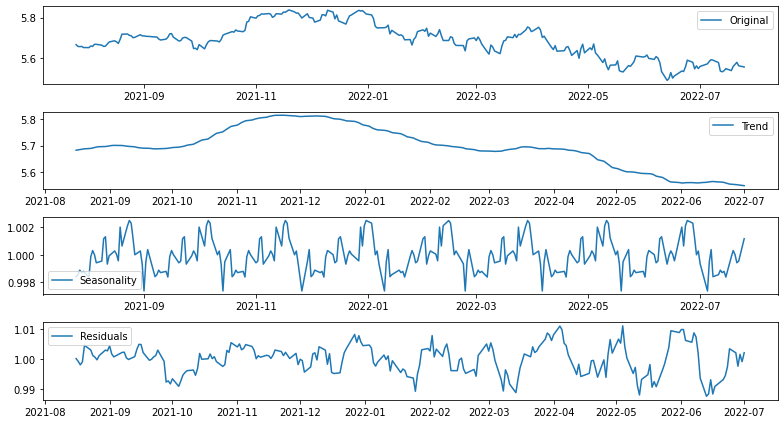

In [7]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', freq = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"]=(11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

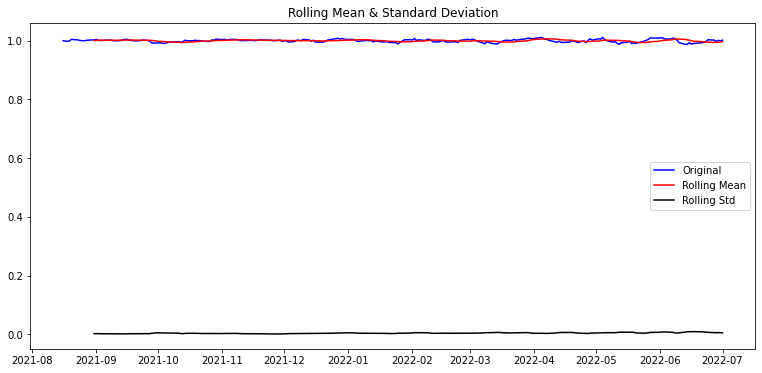

In [8]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [9]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Satistic                 -5.709621e+00
p-value                        7.350955e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.120000e+02
Critical Value (1%)           -3.461578e+00
Critical Value (5%)           -2.875272e+00
Critical Value (10%)          -2.574089e+00
dtype: float64


**학습, 테스트 데이터셋 생성**

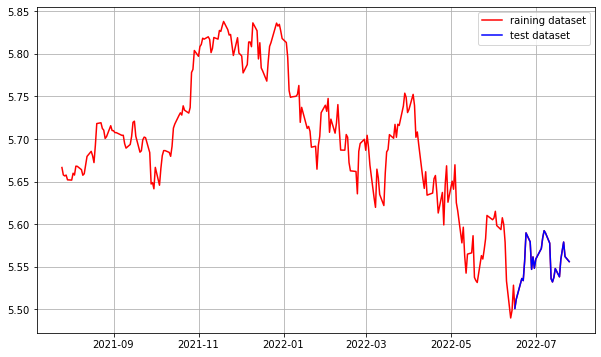

In [10]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='raining dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [11]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2021-07-26    5.666600
2021-07-27    5.657878
Name: Close, dtype: float64
(226,)
(26,)


**적정 ARIMA 모수 찾기**

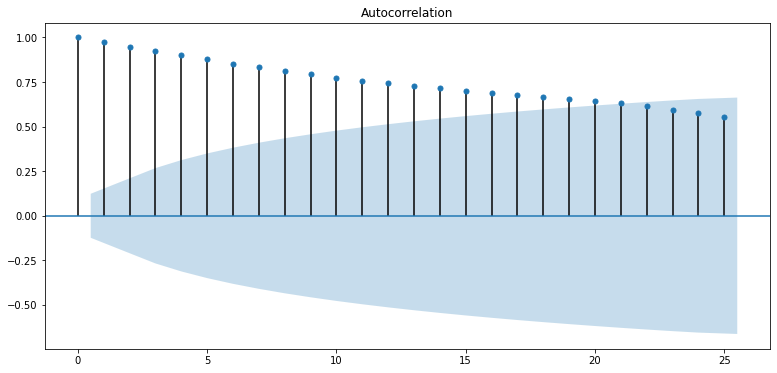

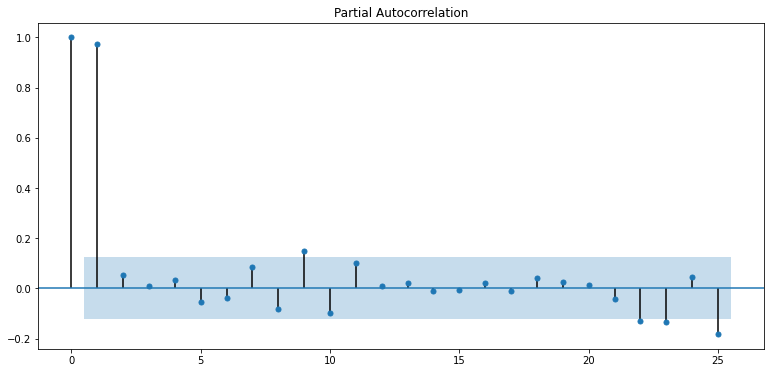

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Satistic                 -1.679037e+01
p-value                        1.243421e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Satistic                 -8.102178e+00
p-value                        1.291007e-12
#Lags Used                     1.000000e+01
Number of Observations Used    2.390000e+02
Critical Value (1%)           -3.458011e+00
Critical Value (5%)           -2.873710e+00
Critical Value (10%)          -2.573256e+00
dtype: float64


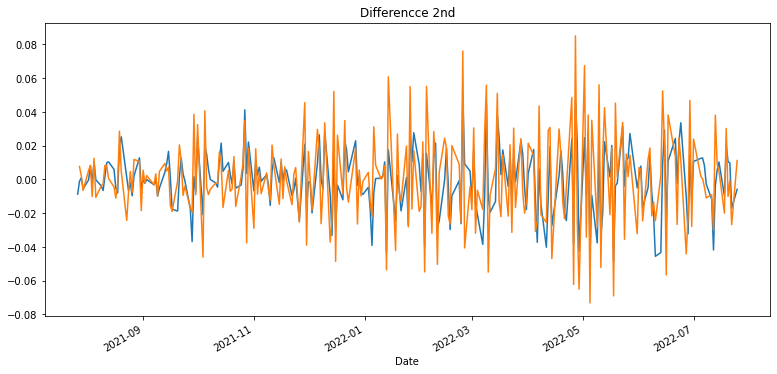

In [13]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Differencce 2nd')

augmented_dickey_fuller_test(diff_2)

**ARIMA 모델 훈련과 테스트**

In [14]:
import warnings
warnings.filterwarnings('ignore')  #경고 무시

from statsmodels.tsa.arima_model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2,0,1))
fitted_m = model.fit()

print(fitted_m.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  226
Model:                     ARMA(2, 1)   Log Likelihood                 582.928
Method:                       css-mle   S.D. of innovations              0.018
Date:                Fri, 29 Jul 2022   AIC                          -1155.856
Time:                        01:48:18   BIC                          -1138.753
Sample:                             0   HQIC                         -1148.954
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.6709      0.048    117.649      0.000       5.576       5.765
ar.L1.Close     0.4410      0.328      1.343      0.181      -0.202       1.084
ar.L2.Close     0.5263      0.320      1.645    

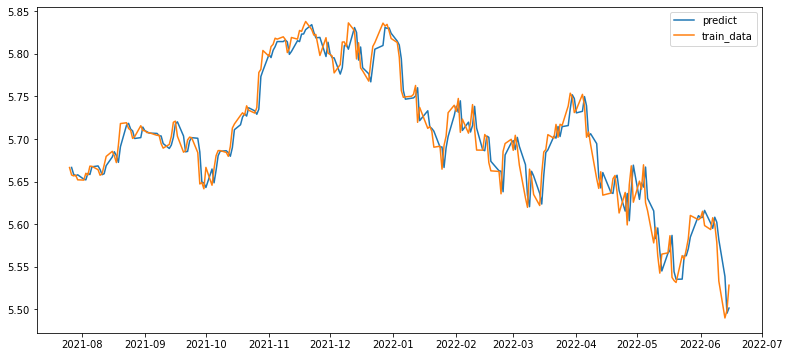

In [15]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

In [16]:
model = ARIMA(train_data, order=(14, 1, 0))  # p값을 14으로 테스트
fitted_m = model.fit()

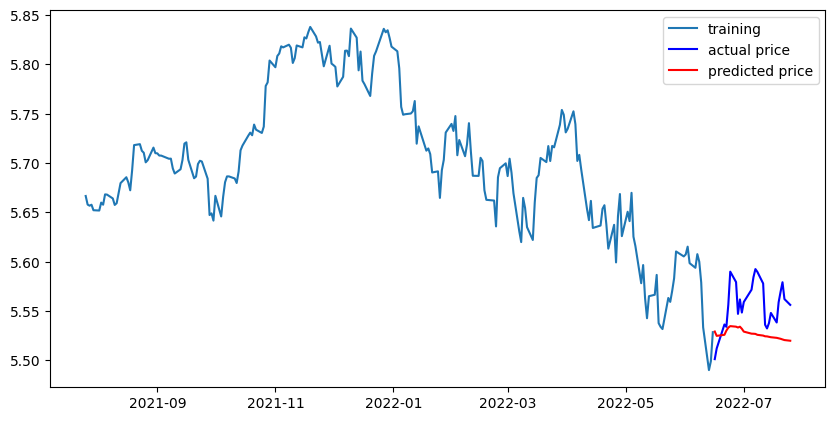

In [17]:
# Forecast : 결과가 fc에 담긴다.
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  93.2325047169674
MAE:  8.337599408613766
RMSE:  9.65569804400321
MAPE: 3.18%


Microsoft 주식의 MAPE는 3.18%로 15%미만의 정확도를 예측하였다.

**다른 주식 종목 예측해보기 1**

In [19]:
dataset_filepath = '/content/drive/MyDrive/colab/ionq/IONQ.csv'  # ionq 주식
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
ts.head()

Date
2021-07-26    9.95
2021-07-27    9.93
2021-07-28    9.93
2021-07-29    9.91
2021-07-30    9.92
Name: Close, dtype: float64

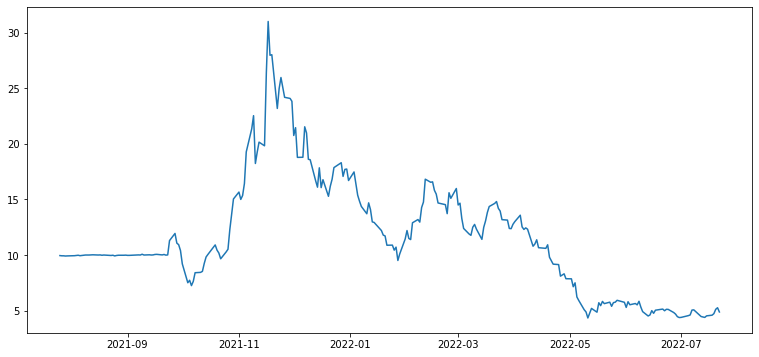

In [20]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 준다.

# 시계열(time series) 데이터를 차트로 그려 본다. 특별히 더 가공하지 않아도 잘 그려진다.
plt.plot(ts)

**각종 전처리 수행**

In [21]:
# 결측치가 있다면 이를 보간한다. 보간 기준은 time을 선택한다.
ts=ts.interpolate(method='time')
ts[ts.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력한다.

Series([], Name: Close, dtype: float64)

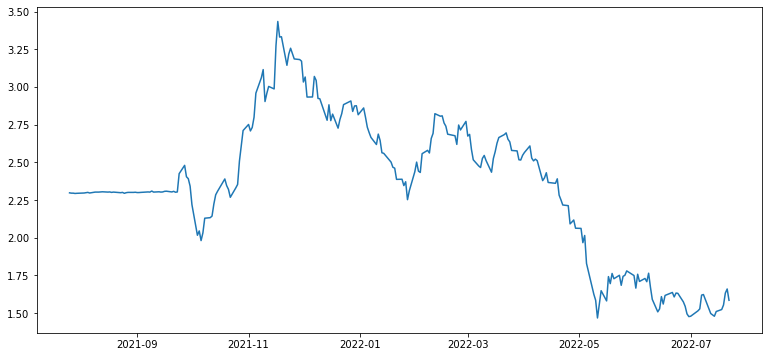

In [22]:
# 로그 변환 시도
ts_log = np.log(ts)
plt.plot(ts_log)

**사계열 안정성 분석**

In [23]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [24]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는  adfuller 메서드를 호출한다.
    dftest = adfuller(timeseries, autolag='AIC')

    # adfuller 메서드가 리턴한 결과를 정리하여 출력한다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Satistic','p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

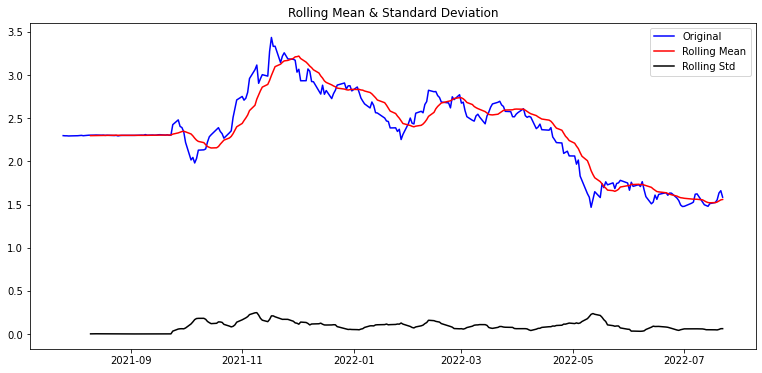

Results of Dickey-Fuller Test:
Test Satistic                   -1.256108
p-value                          0.649006
#Lags Used                      15.000000
Number of Observations Used    235.000000
Critical Value (1%)             -3.458487
Critical Value (5%)             -2.873919
Critical Value (10%)            -2.573367
dtype: float64


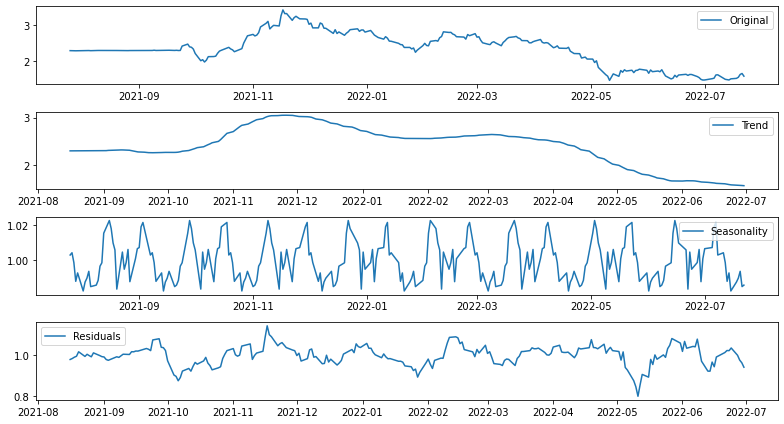

In [25]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', freq = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"]=(11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

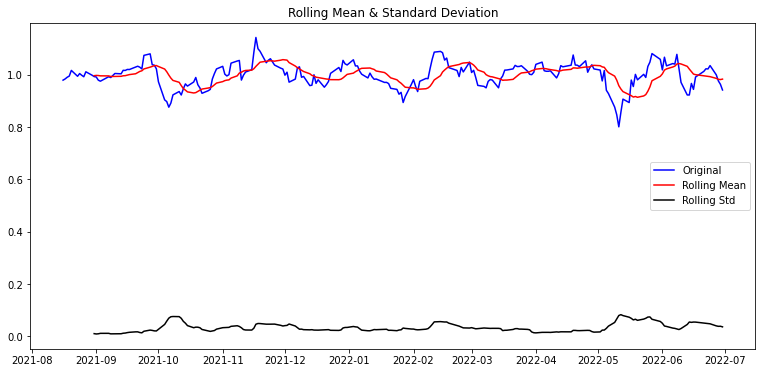

In [26]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [27]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Satistic                   -5.441810
p-value                          0.000003
#Lags Used                      14.000000
Number of Observations Used    206.000000
Critical Value (1%)             -3.462499
Critical Value (5%)             -2.875675
Critical Value (10%)            -2.574304
dtype: float64


**학습, 테스트 데이터셋 생성**

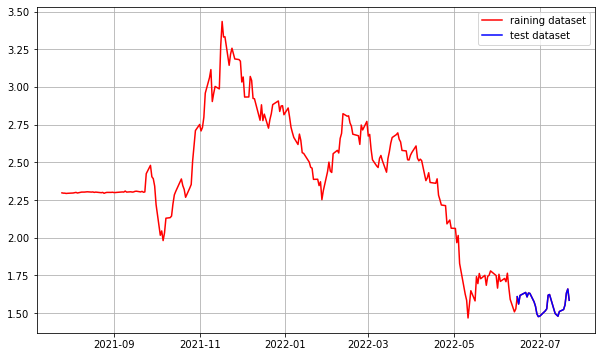

In [28]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='raining dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [29]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2021-07-26    2.297573
2021-07-27    2.295560
Name: Close, dtype: float64
(225,)
(26,)


**적정 ARIMA 모수 찾기**

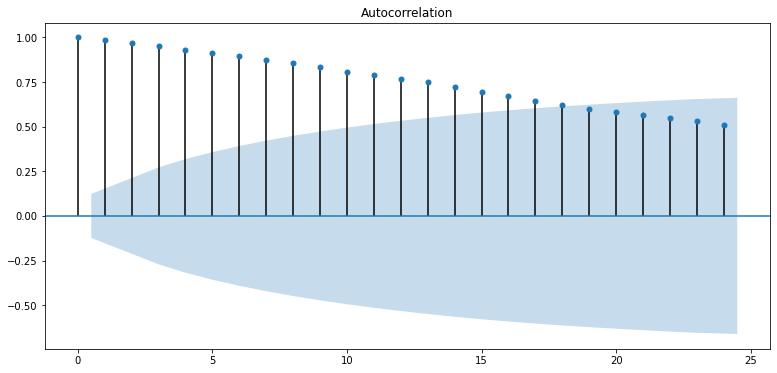

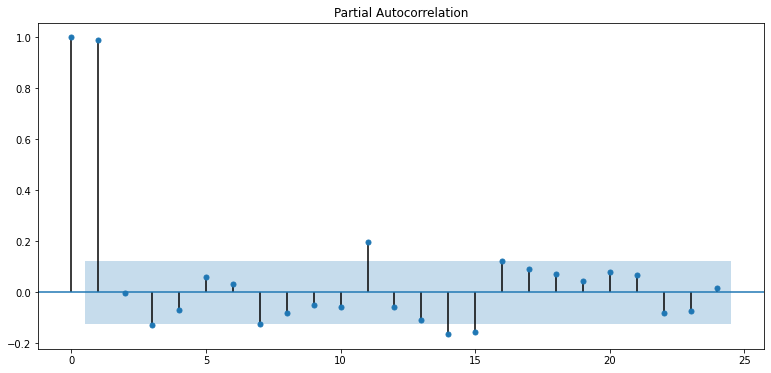

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Satistic                   -3.239349
p-value                          0.017817
#Lags Used                      14.000000
Number of Observations Used    235.000000
Critical Value (1%)             -3.458487
Critical Value (5%)             -2.873919
Critical Value (10%)            -2.573367
dtype: float64
Results of Dickey-Fuller Test:
Test Satistic                 -6.583549e+00
p-value                        7.410930e-09
#Lags Used                     1.300000e+01
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


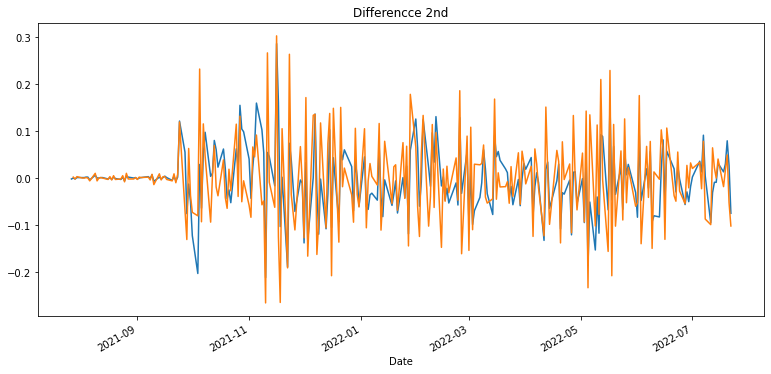

In [31]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Differencce 2nd')

augmented_dickey_fuller_test(diff_2)

**ARIMA 모델 훈련과 테스트**

In [32]:
import warnings
warnings.filterwarnings('ignore')  # 경고 무시

from statsmodels.tsa.arima_model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2,0,1))
fitted_m = model.fit()

print(fitted_m.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  225
Model:                     ARMA(2, 1)   Log Likelihood                 283.093
Method:                       css-mle   S.D. of innovations              0.068
Date:                Fri, 29 Jul 2022   AIC                           -556.186
Time:                        01:48:46   BIC                           -539.105
Sample:                             0   HQIC                          -549.292
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.1942      0.336      6.524      0.000       1.535       2.853
ar.L1.Close     0.2930      0.497      0.589      0.556      -0.682       1.268
ar.L2.Close     0.6893      0.492      1.401    

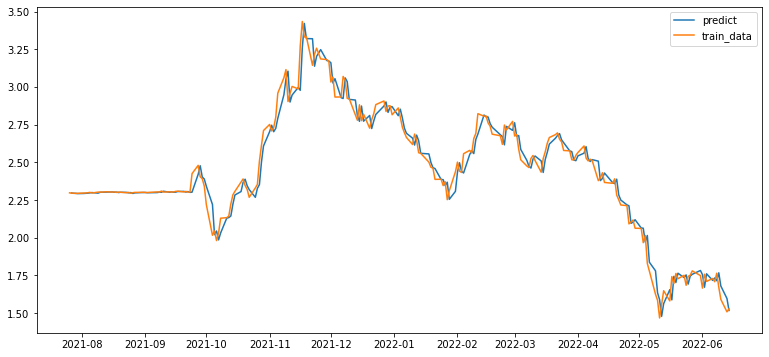

In [33]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

In [34]:
model = ARIMA(train_data, order=(14, 1, 0))  # p값을 14으로 테스트
fitted_m = model.fit()

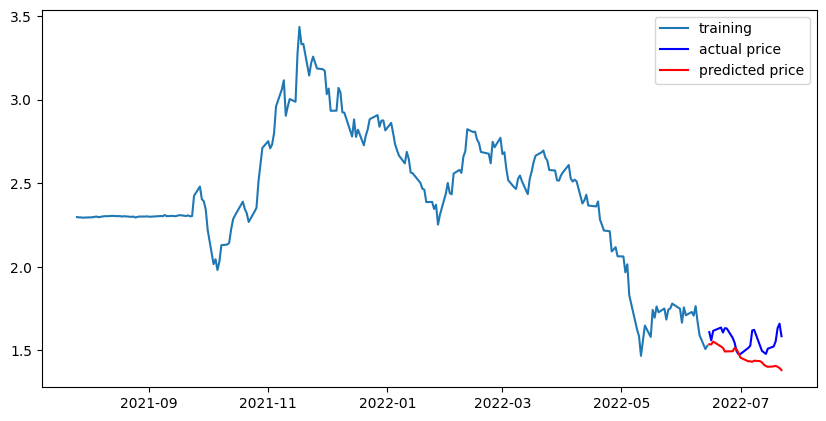

In [35]:
# Forecast : 결과가 fc에 담긴다.
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  0.31898237266682017
MAE:  0.47602115169324044
RMSE:  0.564785244731854
MAPE: 9.73%


IONQ 주식의 MAPE는 9.73%로 15%미만의 정확도를 예측하였다.

**다른 주식 종목 예측해보기 2**

In [37]:
dataset_filepath = '/content/drive/MyDrive/colab/tesla/TSLA.csv'  # tesla 주식
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
ts.head()

Date
2021-07-26    657.619995
2021-07-27    644.780029
2021-07-28    646.979980
2021-07-29    677.349976
2021-07-30    687.200012
Name: Close, dtype: float64

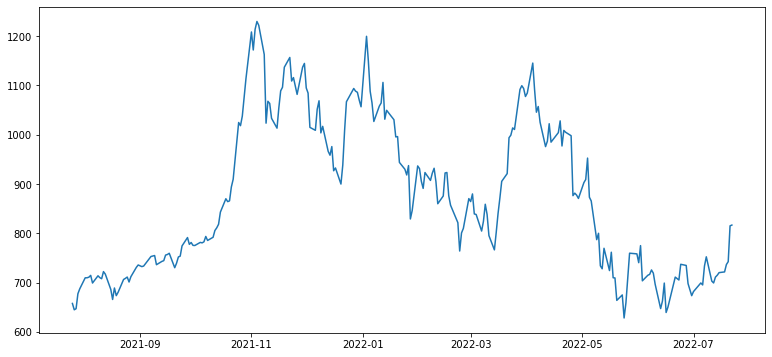

In [38]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 준다.

# 시계열(time series) 데이터를 차트로 그려 본다. 특별히 더 가공하지 않아도 잘 그려진다.
plt.plot(ts)

**각종 전처리 수행**

In [39]:
# 결측치가 있다면 이를 보간한다. 보간 기준은 time을 선택한다.
ts=ts.interpolate(method='time')
ts[ts.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력한다.

Series([], Name: Close, dtype: float64)

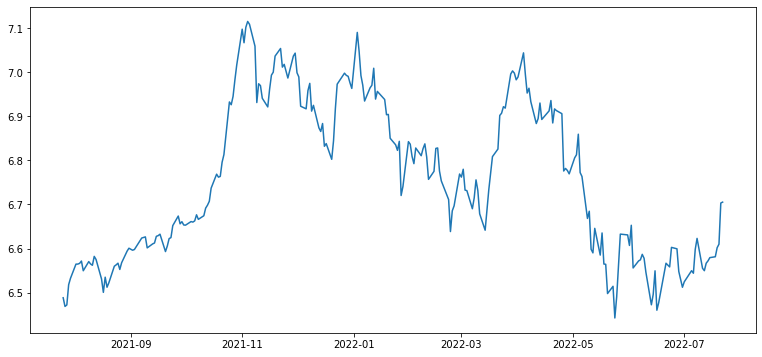

In [40]:
# 로그 변환 시도
ts_log = np.log(ts)
plt.plot(ts_log)

**사계열 안정성 분석**

In [41]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [42]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는  adfuller 메서드를 호출한다.
    dftest = adfuller(timeseries, autolag='AIC')

    # adfuller 메서드가 리턴한 결과를 정리하여 출력한다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Satistic','p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

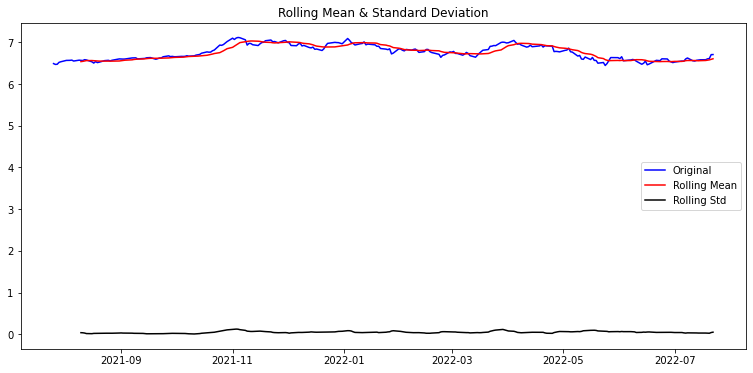

Results of Dickey-Fuller Test:
Test Satistic                   -1.903388
p-value                          0.330469
#Lags Used                      10.000000
Number of Observations Used    240.000000
Critical Value (1%)             -3.457894
Critical Value (5%)             -2.873659
Critical Value (10%)            -2.573229
dtype: float64


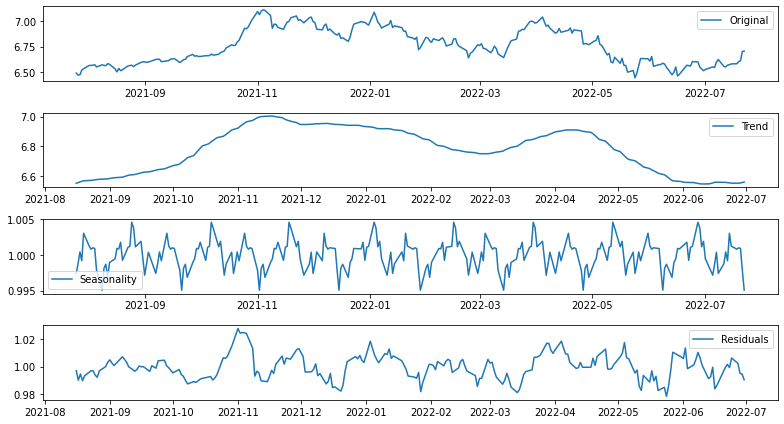

In [56]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', freq= 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"]=(11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

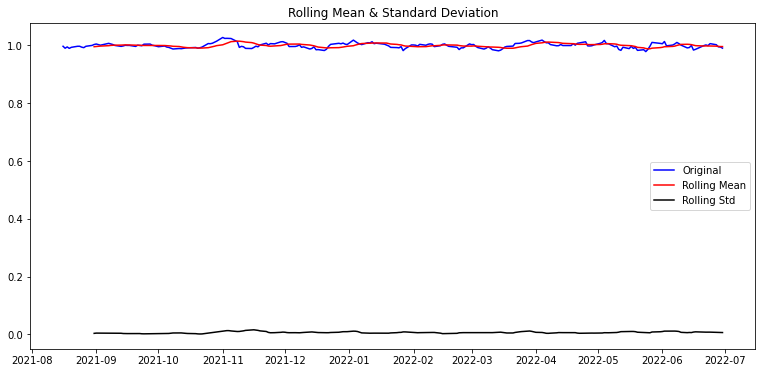

In [44]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [45]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Satistic                   -5.495261
p-value                          0.000002
#Lags Used                       9.000000
Number of Observations Used    211.000000
Critical Value (1%)             -3.461727
Critical Value (5%)             -2.875337
Critical Value (10%)            -2.574124
dtype: float64


**학습, 테스트 데이터셋 생성**

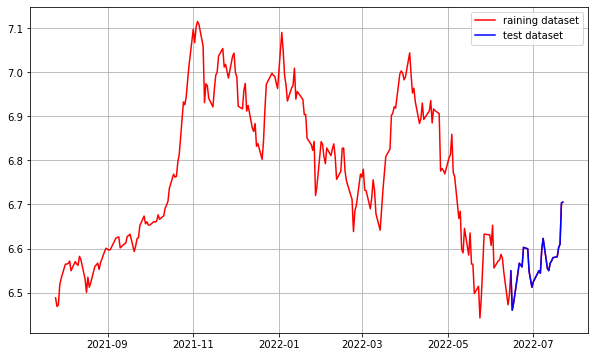

In [46]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='raining dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [47]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2021-07-26    6.488627
2021-07-27    6.468909
Name: Close, dtype: float64
(225,)
(26,)


**적정 ARIMA 모수 찾기**

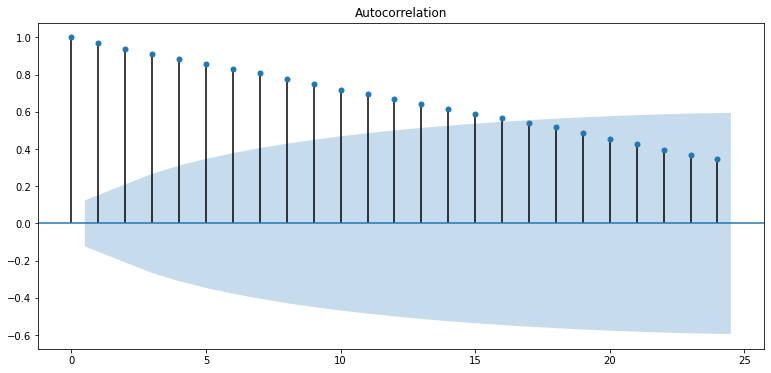

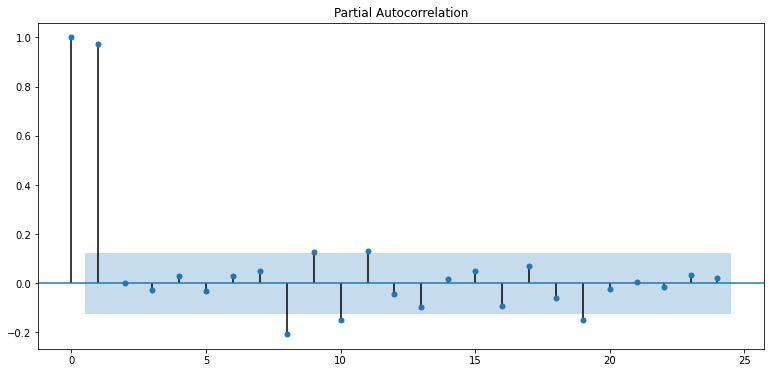

In [48]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Satistic                   -4.973561
p-value                          0.000025
#Lags Used                       9.000000
Number of Observations Used    240.000000
Critical Value (1%)             -3.457894
Critical Value (5%)             -2.873659
Critical Value (10%)            -2.573229
dtype: float64
Results of Dickey-Fuller Test:
Test Satistic                 -6.742737e+00
p-value                        3.089282e-09
#Lags Used                     1.600000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


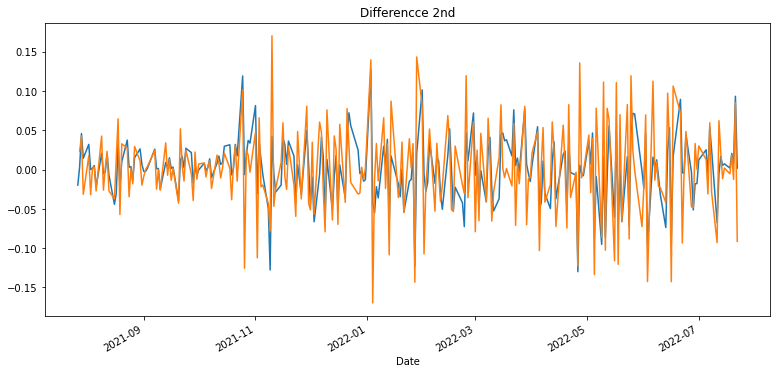

In [49]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Differencce 2nd')

augmented_dickey_fuller_test(diff_2)

**ARIMA 모델 훈련과 테스트**

In [50]:
import warnings
warnings.filterwarnings('ignore')  #경고 무시

from statsmodels.tsa.arima_model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2,0,1))
fitted_m = model.fit()

print(fitted_m.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  225
Model:                     ARMA(2, 1)   Log Likelihood                 407.938
Method:                       css-mle   S.D. of innovations              0.039
Date:                Fri, 29 Jul 2022   AIC                           -805.877
Time:                        01:49:05   BIC                           -788.796
Sample:                             0   HQIC                          -798.983
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.6885      0.115     58.105      0.000       6.463       6.914
ar.L1.Close     0.4397      0.346      1.270      0.205      -0.239       1.118
ar.L2.Close     0.5301      0.339      1.565    

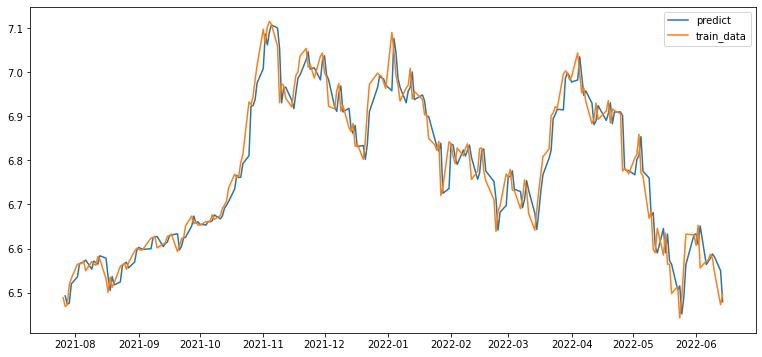

In [51]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

In [52]:
model = ARIMA(train_data, order=(14, 1, 0))  # p값을 14으로 테스트
fitted_m = model.fit()

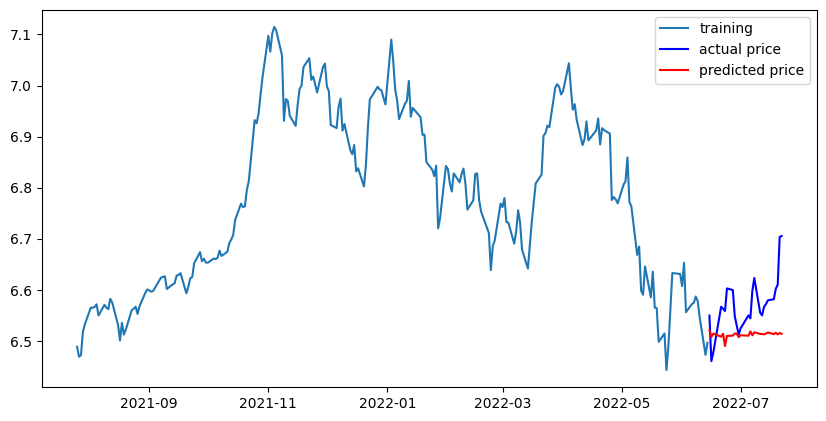

In [53]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3202.927721439358
MAE:  45.67375762455448
RMSE:  56.59441422472149
MAPE: 6.19%


tesla 주식의 MAPE는 6.19%로 15%미만의 정확도를 예측하였다.

✍ **회고**

* 세 가지 종목으로 Microsoft, IONQ, TESLA를 이용하여 프로젝트를 진행하였다. Microsoft의 MAPE는 3.18%, IONQ의 MAPE는 9.73%, TESLA의 MAPE는 6.19%를 기록하였다. 세 종목 모두 MAPE가 15% 미만의 정확도로 예측되어 무사히 주식 예측을 끝낼 수 있었다.

* seasonal_decompose에 인수를 periode를 적용하였을 때,  seasonal_decompose() got an unexpected keyword argument 'period' 라는 에러 메시지가 떴다. 그래서 freq로 변경해주었더니 무사히 실행될 수 있었다.

* 평소 관심있던 주식들을 분석하고 이해하는 과정을 진행해서 내용이 더욱 흥미로웠다. 주식은 예측불가한 점이 큰 특징인데, 이를 예측한다는 것이 신선했다. 가격이 적당하면서 괜찮은 종목을 찾으면, 주식 예측 프로그램을 이용해서 매수해보고 싶다.